In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip
from collections import defaultdict
import glob, os
import matplotlib.ticker as mticker
import seaborn as sns

In [181]:
# hierarchy:
# plot_multi_threads.ipynb
#                        ./ multithreads / blackschole / result-xxxx-4.0GHz+maxFreq+slowDVFS_parsec-swaptions-simsmall-1 / sim.out

In [191]:
# set the benchmark and cache level here
cache_level = 'L1'

In [192]:
path = './multithreads/'
frequency = 4
freq_mode = 'maxFreq'
DVFS_mode = 'slowDVFS'
input_set = 'simsmall'
threads_dict = {
        'parsec-blackscholes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
        'parsec-bodytrack': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
        'parsec-canneal': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
        'parsec-dedup': [4, 7, 10, 13, 16],
        'parsec-fluidanimate': [2, 3, 0, 5, 0, 0, 0, 9],
        'parsec-streamcluster': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
        'parsec-swaptions': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
        'parsec-x264': [1, 3, 4, 5, 6, 7, 8, 9]
}

In [193]:
# cache hardcord indices
cache_dict = {
    "L1": 37,
    "L2": 42,
    "L3": 47
}

In [194]:
def get_cm_from_sim(benchmark):
    results = {}
    for subdir in os.listdir(path + benchmark +'/'):
        # get the subdirectory name and use it to open file
        with open(path + benchmark +'/'+str(subdir) + '/' + 'sim.out', 'rb') as file:         # rb: binary
            lines = file.readlines()
            threads = threads_dict['parsec-' + benchmark]
            
            thread_num = threads[int(str(subdir)[-1])-1]
            #       firstline; remove '/n'; binary -> string; remove ','&' '; separate by '|'
            cores = lines[0].strip().decode('ascii').replace(',','').replace(' ', '').split('|')[1:thread_num+1]    
            #times = lines[4].strip().decode('ascii').replace(',','').replace(' ', '').split('|')[1:thread_num]
            result_dict = {}
            for cache, index in cache_dict.items():
                cm = lines[index].strip().decode('ascii').replace(',','').replace(' ', '').split('|')[1:thread_num+1]
                cm = [eval(i[:4]) for i in cm] #to int
                result_dict[cache] = cm
            results[thread_num] = result_dict
    results = dict(sorted(results.items()))
    return results

In [195]:
# generate lists for plotting lines
x_a = [] # 2-dimension array
y_a = {} # a dict

x_label = 'Thread num'
y_label = 'Miss rate(%)'
labels = []
# open files and get results

for benchmark in os.listdir(path +'/'):
    res = get_cm_from_sim(benchmark)
    labels.append(benchmark)
    y_temp = {}
    x_temp = []
    for key, item in res.items():
        x_temp.append(key)
        y_temp[key] = item[cache_level]
    y_a[benchmark] = y_temp
    x_a.append(x_temp)

In [196]:
title = '' # TODO
labels

['blackscholes',
 'bodytrack',
 'canneal',
 'fluidanimate',
 'streamcluster',
 'swaptions',
 'x264']

In [197]:
x_a

[[2, 3, 4], [3, 4], [2, 3, 4], [2, 3], [2, 3, 4], [2, 3, 4], [3, 4]]

In [198]:
y_a

{'blackscholes': {2: [0.06, 0.31],
  3: [0.07, 0.31, 0.31],
  4: [0.07, 0.31, 0.31, 0.3]},
 'bodytrack': {3: [1.48, 3.51, 1.79], 4: [1.48, 3.54, 3.52, 1.79]},
 'canneal': {2: [3.21, 6.21],
  3: [3.21, 6.22, 6.21],
  4: [3.21, 6.21, 6.21, 6.21]},
 'fluidanimate': {2: [0.36, 0.48], 3: [0.42, 0.45, 0.46]},
 'streamcluster': {2: [1.0, 4.28],
  3: [1.0, 4.24, 4.22],
  4: [1.0, 4.13, 4.31, 4.28]},
 'swaptions': {2: [2.15, 1.1],
  3: [2.15, 1.1, 1.1],
  4: [2.15, 1.11, 1.11, 1.11]},
 'x264': {3: [1.98, 2.29, 3.19], 4: [1.98, 2.14, 3.01, 3.72]}}

In [204]:
benchmark = 'streamcluster' # set benchmark here

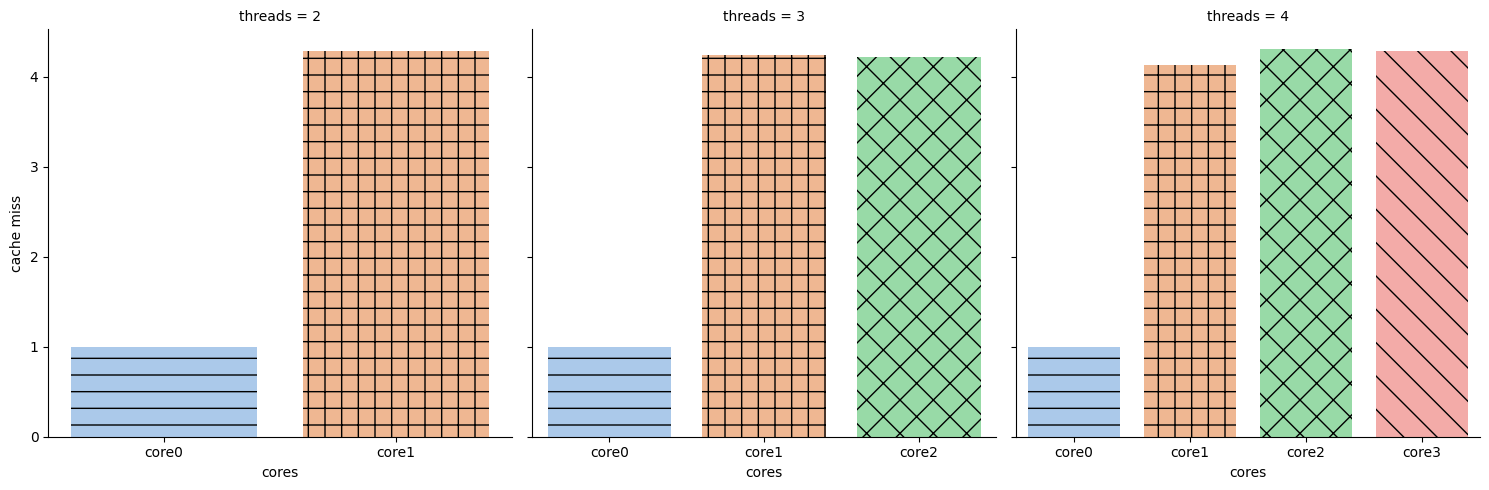

In [203]:
# https://stackoverflow.com/questions/66850941/how-to-generate-a-group-bar-plot-with-different-numbers-of-bars-in-each-group
df = pd.DataFrame({'threads': [t for t in y_a[benchmark].keys() for _ in range(t)],
                   'cores': ['core'+str(tt) for t in y_a[benchmark].keys() for tt in range(t) ],
                   'cache miss': [v for values in y_a[benchmark].values() for v in values ]})
df
# Define some hatches
hatches = ['-', '+', 'x', '\\', '*', 'o']
g = sns.catplot(kind='bar', data=df, col='threads', x='cores', y='cache miss',
                hue='cores', palette='pastel', dodge=False, sharex=False)
# Loop over the bars
#ax.annotate(percentage, (x, y))
for i in range(len(y_a[benchmark])):
    for j,thisbar in enumerate(g.axes[0][i].patches):
        # Set a different hatch for each bar
        thisbar.set_hatch(hatches[j])
        #thisbar.bar_label(j,)
        
        
plt.tight_layout()
plt.show()

In [205]:
df

,threads,cores,cache miss
0,2,core0,1.00
1,2,core1,4.28
2,3,core0,1.00
3,3,core1,4.24
4,3,core2,4.22
5,4,core0,1.00
6,4,core1,4.13
7,4,core2,4.31
8,4,core3,4.28
